In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [2]:
def resize_image (img, new_width=256, new_height=256):
    height, width = img.shape[:2]
    
    scale_x = width / new_width
    scale_y = height / new_height
    resized_img = np.zeros((new_height, new_width, 3), dtype=np.uint8)
    
    for i in range(new_height):
        for j in range(new_width):
            orig_x = int(j * scale_x)
            orig_y = int(i * scale_y)
            resized_img[i, j] = img[orig_y, orig_x]  
    return resized_img

In [3]:
def insertGambar(folder):
    data = []
    filenames = []
    datalabel = [] 
    path = []
    data_distribution = {}
    for label in (os.listdir(folder)):
        images = os.listdir(folder+label)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(label)
        count = 0
        for filename in tqdm(os.listdir(folder+label)):
            if count == 100:
                break
            else :
                count += 1
            img = cv.imread(os.path.join(folder+label,filename))
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = resize_image(img, 512, 512)
                filenames.append(filename)
                path.append(label)
                data.append(img)
    return data, filenames, datalabel, path , data_distribution

In [4]:
images, filenames, labels, path, distribusi = insertGambar("Dataset2/")

print("Jumlah gambar:", len(images))
print("Jumlah label unik:", len(labels))
print("Jumlah nama file:", len(filenames))
print("Distribusi data:", distribusi)


Acne Vulgaris


100%|██████████| 100/100 [00:10<00:00,  9.62it/s]


Rosacea


100%|██████████| 100/100 [00:10<00:00,  9.94it/s]


Jumlah gambar: 200
Jumlah label unik: 2
Jumlah nama file: 200
Distribusi data: {'Acne Vulgaris': 100, 'Rosacea': 100}


In [5]:
def display_sample(images):
  plt.figure(figsize=(20,10))
  for i in range(7):
    plt.subplot(1,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap='gray')
  plt.show()    

In [6]:
def gray_scaling(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return gray

In [7]:
def gaussian_kernel(size: int, sigma: float) -> np.ndarray:
    ax = np.arange(-size // 2 + 1., size // 2 + 1.)
    kernel = np.zeros((size, size), dtype=np.float64)

    for i in range(size):
        for j in range(size):
            x = ax[j]  
            y = ax[i]  
            kernel[i, j] = np.exp(-(x**2 + y**2) / (2. * sigma**2))

    return kernel / np.sum(kernel)

def konvolusi(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    img_h, img_w = image.shape
    k_h, k_w = kernel.shape
    pad_h = k_h // 2
    pad_w = k_w // 2

    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')
    output = np.zeros_like(image, dtype=np.float64)

    for i in range(img_h):
        for j in range(img_w):
            region = padded_image[i:i+k_h, j:j+k_w]
            output[i, j] = np.sum(region * kernel)

    return np.clip(output, 0, 255).astype(np.uint8)

def gaussian_blur(image: np.ndarray, kernel_size: int = 3, sigma: float = 0.0) -> np.ndarray:
    if sigma == 0.0:
        sigma = 0.3 * ((kernel_size - 1) * 0.5 - 1) + 0.8

    kernel = gaussian_kernel(kernel_size, sigma)
    blurred = konvolusi(image, kernel)
    return blurred


In [8]:
def sobel(image):
    sobel_x = np.array([[1, 0, -1], 
                        [2, 0, -2], 
                        [1, 0, -1]])
    sobel_y = np.array([[1, 2, 1], 
                        [0, 0, 0], 
                        [-1, -2, -1]])
    
    padded_img = np.pad(image, pad_width=1, mode='constant', constant_values=0)
    sobel_result = np.zeros_like(image, dtype=np.uint8)
    
    for i in range(1, padded_img.shape[0] - 1):
        for j in range(1, padded_img.shape[1] - 1):
            region = padded_img[i-1:i+2, j-1:j+2]

            gx = np.sum(region * sobel_x)
            gy = np.sum(region * sobel_y)

            sobel_result[i-1, j-1] = np.sqrt(gx**2 + gy**2)
    sobel_result = (sobel_result / np.max(sobel_result) * 255).astype(np.uint8)
    
    return sobel_result

In [9]:
def erosi(citra, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(citra, pad, mode='constant')
    result = np.zeros_like(citra)
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i, j] = np.min(region[kernel == 1])
    return result

def dilasi(citra, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(citra, pad, mode='constant')
    result = np.zeros_like(citra)
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i, j] = np.max(region[kernel == 1])
    return result

def opening(citra):
    kernel = np.ones((3, 3), dtype=np.uint8)
    citra_erosi = erosi(citra, kernel)
    citra_opening = dilasi(citra_erosi, kernel)
    return citra_opening


In [10]:
def normalize(image, skala_min=0, skala_max=255):
    image = image.astype(np.float32)
    min_val, max_val = np.min(image), np.max(image)

    if max_val == min_val:
        return np.full(image.shape, skala_min, dtype=np.uint8)  

    return ((image - min_val) * (skala_max - skala_min) / (max_val - min_val) + skala_min).astype(np.uint8)

In [11]:
def median_filtering(img):
    pad = 1
    padded_img = np.pad(img, pad, mode='edge')
    result = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            window = padded_img[i:i+3, j:j+3].flatten()
            result[i, j] = np.median(window)
    return result

In [ ]:
dataPreprocessed = []
for i in range(len(images)):  
    resize_img = resize_image(images[i], 512, 512)  
    gray_img = gray_scaling(resize_img)  
    blurred = gaussian_blur(gray_img, kernel_size=10, sigma=0)
    citra_sobel = sobel(blurred)
    citra_opening = opening(citra_sobel)
    normalizeData = normalize(citra_opening)  

    dataPreprocessed.append(normalizeData)

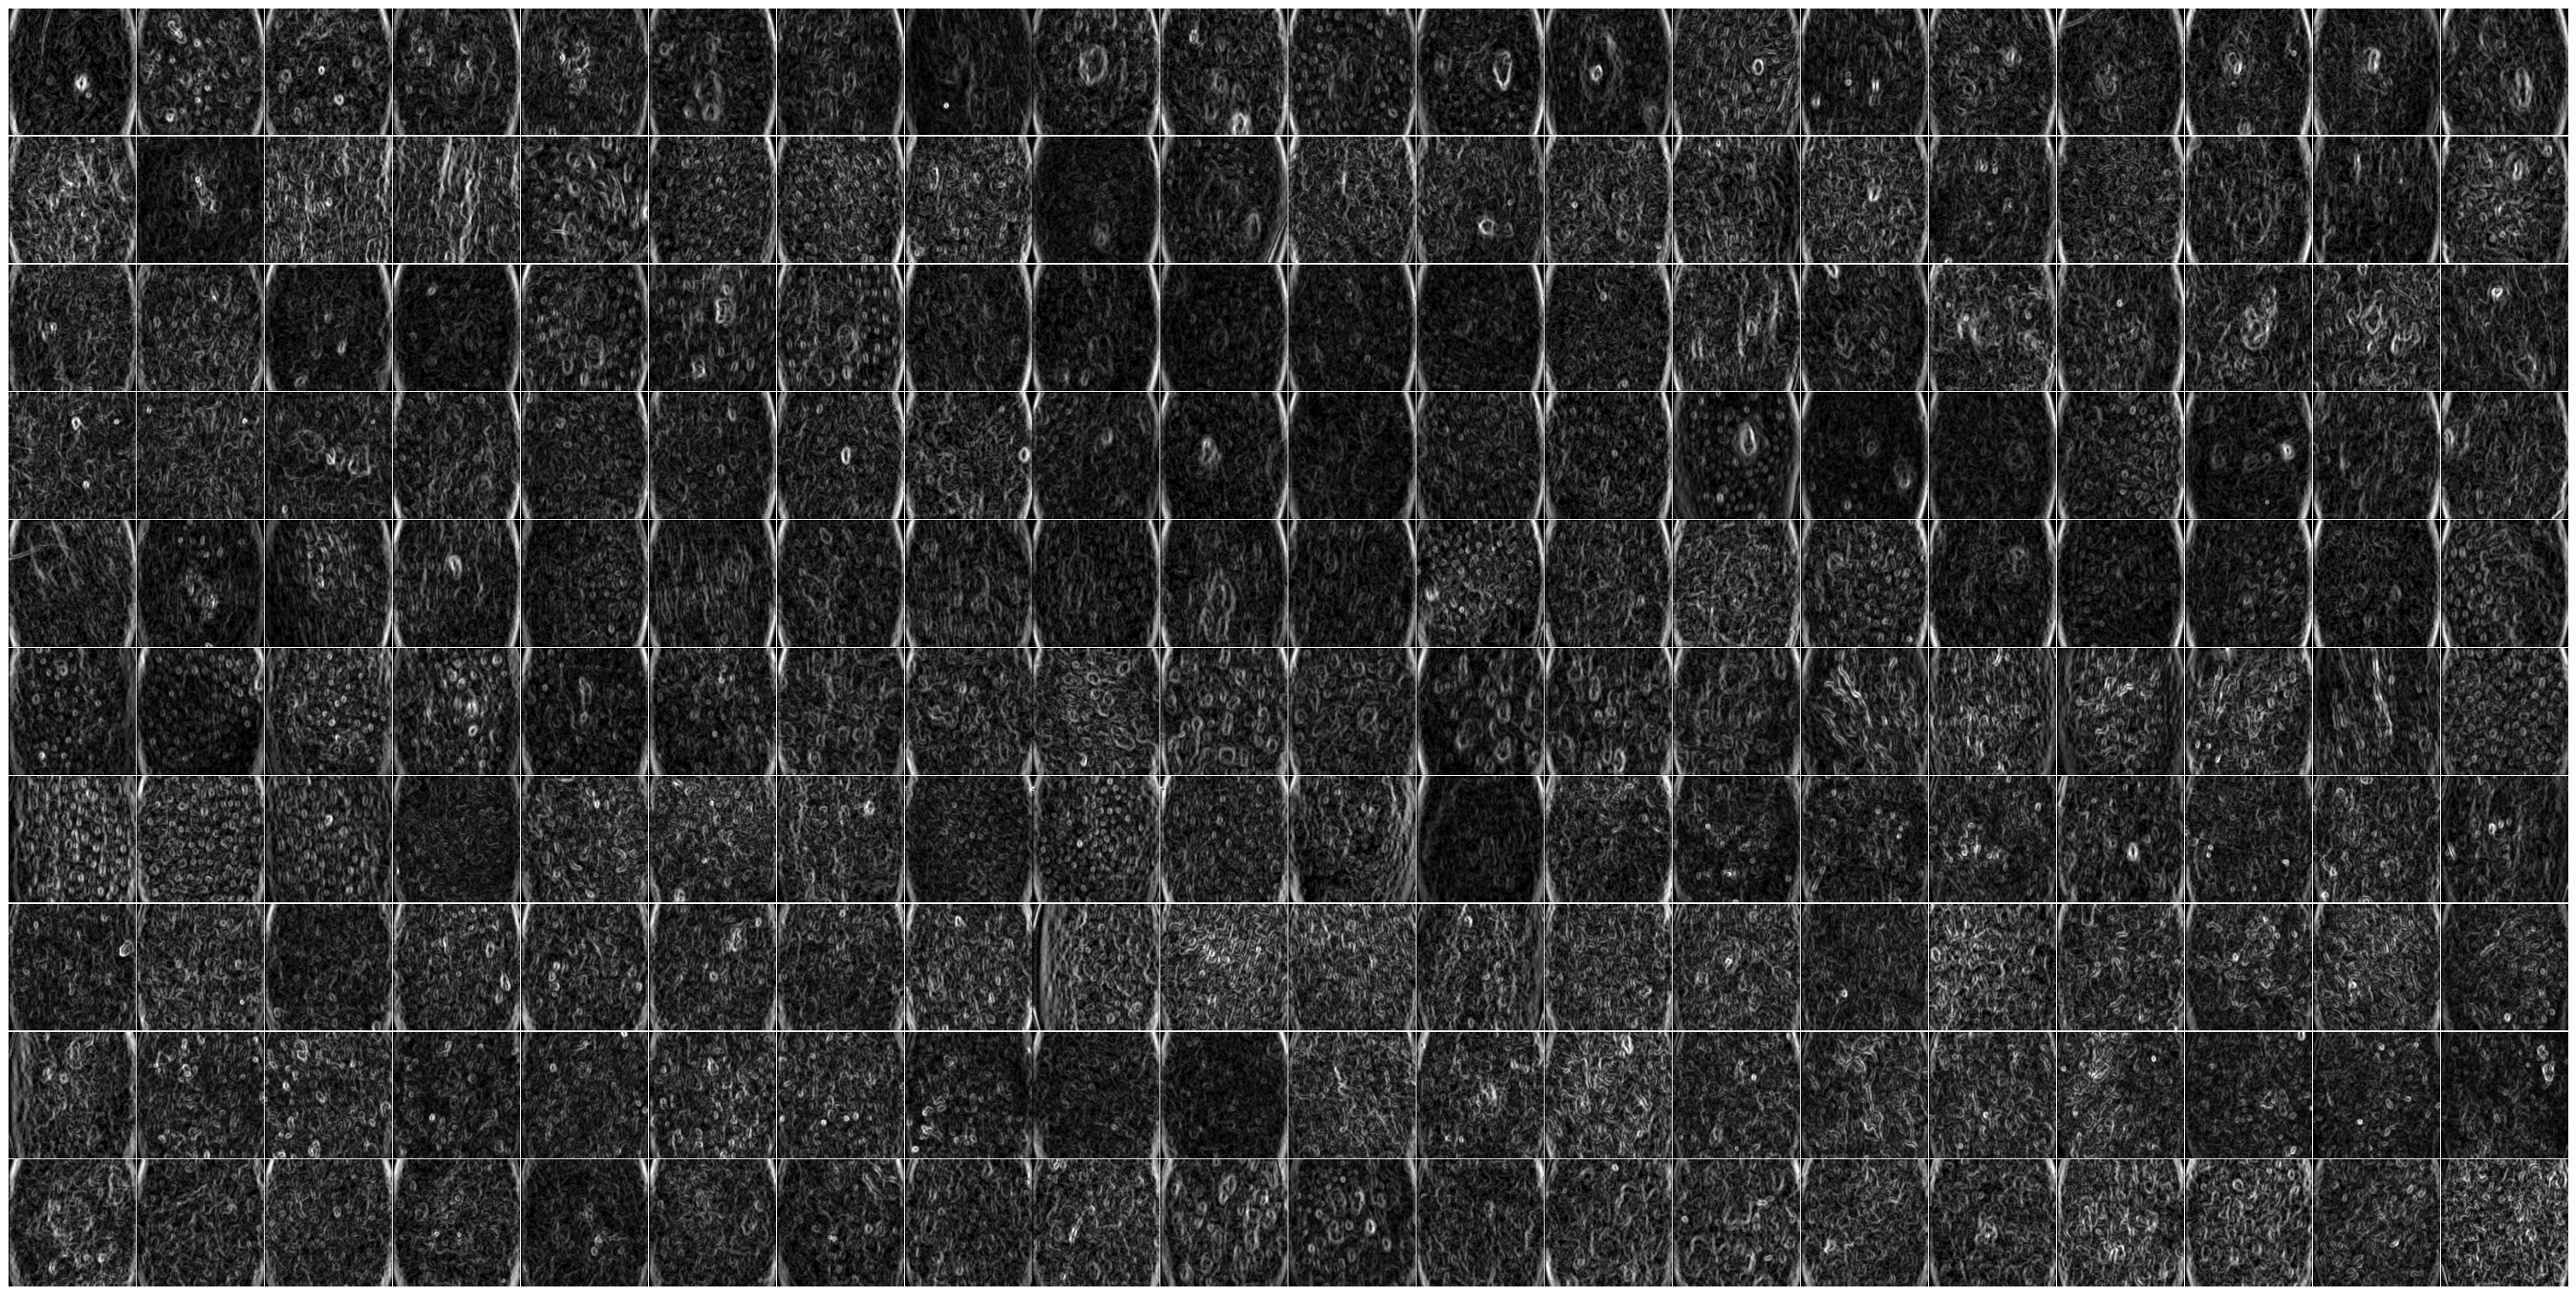

In [ ]:
num_images = min(len(images), 200)  

cols = 20  
rows = (num_images // cols) + (1 if num_images % cols else 0)  

fig, axes = plt.subplots(rows, cols, figsize=(30, 15))

for i, ax in enumerate(axes.flat):
    
    if i < num_images:
        img = resize_image(dataPreprocessed[i])  
        ax.imshow(img, cmap='gray')
        ax.axis("off")
    else:
        ax.axis("off")  

plt.tight_layout(pad=0.1)  
plt.show()

<h1>Feature Extraction</h1>

In [ ]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [ ]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [ ]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [ ]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [ ]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [ ]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [ ]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [ ]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [ ]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [ ]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [ ]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    homogenity0.append(H0)
    H45 = homogenity(Derajat45[i])
    homogenity45.append(H45)
    H90 = homogenity(Derajat90[i])
    homogenity90.append(H90)
    H135 = homogenity(Derajat135[i])
    homogenity135.append(H135)

In [ ]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [ ]:
for i in range(len(images)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [ ]:
for i in range(len(images)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [ ]:
for i in range(len(images)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [ ]:
for i in range(len(images)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [ ]:
for i in range(len(images)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [ ]:
print("Jumlah Labels:", len(path))
print("Jumlah Filename:", len(filenames))
print("Jumlah Kontras0:", len(Kontras0), len(Kontras45), len(Kontras90), len(Kontras135))
print("Jumlah Homogeneity0:", len(homogenity0), len(homogenity45), len(homogenity90), len(homogenity135))
print("Jumlah Dissimilarity0:", len(dissimilarity0), len(dissimilarity45), len(dissimilarity90), len(dissimilarity135))
print("Jumlah Entropy0:", len(entropy0), len(entropy45), len(entropy90), len(entropy135))
print("Jumlah ASM0:", len(ASM0), len(ASM45), len(ASM90), len(ASM135))
print("Jumlah Energy0:", len(energy0), len(energy45), len(energy90), len(energy135))
print("Jumlah Correlation0:", len(correlation0), len(correlation45), len(correlation90), len(correlation135))

Jumlah Labels: 200
Jumlah Filename: 200
Jumlah Kontras0: 200 200 200 200
Jumlah Homogeneity0: 200 200 200 200
Jumlah Dissimilarity0: 200 200 200 200
Jumlah Entropy0: 200 200 200 200
Jumlah ASM0: 200 200 200 200
Jumlah Energy0: 200 200 200 200
Jumlah Correlation0: 200 200 200 200


<h1>CSV</h1>

In [ ]:
dataTable = {'Filename': filenames, 'Label': path,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_5.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_5.csv')
hasilEkstrak

Filename          Label   Contrast0  Contrast45  Contrast90  \
0    101_5.jpg  Acne Vulgaris  166.936428  228.987497   79.187194   
1    102_2.jpg  Acne Vulgaris  191.682077  242.467466  112.620925   
2    103_2.jpg  Acne Vulgaris  207.536259  289.044075  119.467004   
3    106_1.jpg  Acne Vulgaris  176.241927  222.840723   77.118490   
4    106_7.jpg  Acne Vulgaris  185.324954  245.853133   73.102926   
..         ...            ...         ...         ...         ...   
195  118_2.jpg        Rosacea  232.648376  316.199800  132.005070   
196  118_3.jpg        Rosacea  435.918857  544.329750  195.484743   
197  118_4.jpg        Rosacea  384.962316  537.754433  194.414001   
198  119_1.jpg        Rosacea  216.147809  333.388712  141.101134   
199  119_2.jpg        Rosacea  546.772886  756.741915  317.930515   

     Contrast135  Homogeneity0  Homogeneity45  Homogeneity90  Homogeneity135  \
0     196.104022      0.550338       0.410422       0.598937        0.421573   
1     295.127951      0.444652       0.297796       0.481719        0.292273   
2     279.800492      0.509347       0.360159       0.548179        0.367958   
3     226.547359      0.484237       0.339274       0.539629        0.338960   
4     214.310250      0.453435       0.304905       0.507783        0.312137   
..           ...           ...            ...            ...             ...   
195   323.562860      0.486065       0.335532       0.518892        0.331365   
196   579.497916      0.435175       0.280901       0.473526        0.278907   
197   483.731642      0.473065       0.318268       0.509292        0.323156   
198   277.374779      0.464905       0.297310       0.481731        0.306769   
199   743.635448      0.478880       0.315132       0.501041        0.315093   

     ...     ASM90    ASM135   Energy0  Energy45  Energy90  Energy135  \
0    ...  0.055126  0.035474  0.216803  0.184878  0.234788   0.188346   
1    ...  0.021021  0.011715  0.133261  0.110533  0.144985   0.108234   
2    ...  0.039940  0.024859  0.186895  0.155336  0.199850   0.157667   
3    ...  0.033053  0.018901  0.164187  0.137320  0.181805   0.137481   
4    ...  0.026756  0.014528  0.143466  0.118535  0.163574   0.120533   
..   ...       ...       ...       ...       ...       ...        ...   
195  ...  0.032780  0.019211  0.168713  0.139759  0.181054   0.138605   
196  ...  0.020782  0.011172  0.130873  0.106424  0.144159   0.105697   
197  ...  0.030212  0.017634  0.159993  0.131127  0.173816   0.132792   
198  ...  0.024340  0.014531  0.148337  0.117640  0.156014   0.120546   
199  ...  0.029586  0.016991  0.161880  0.130050  0.172006   0.130351   

     Correlation0  Correlation45  Correlation90  Correlation135  
0        0.944022       0.923122       0.973511        0.934162  
1        0.926557       0.907079       0.956930        0.886898  
2        0.918556       0.886407       0.953095        0.890040  
3        0.926253       0.906651       0.968001        0.905098  
4        0.890949       0.855197       0.957072        0.873775  
..            ...            ...            ...             ...  
195      0.904298       0.869696       0.945696        0.866663  
196      0.876595       0.845822       0.944712        0.835860  
197      0.888263       0.843609       0.943496        0.859320  
198      0.870944       0.800667       0.915724        0.834156  
199      0.839038       0.777183       0.906480        0.781043  

[200 rows x 30 columns]

<Axes: >

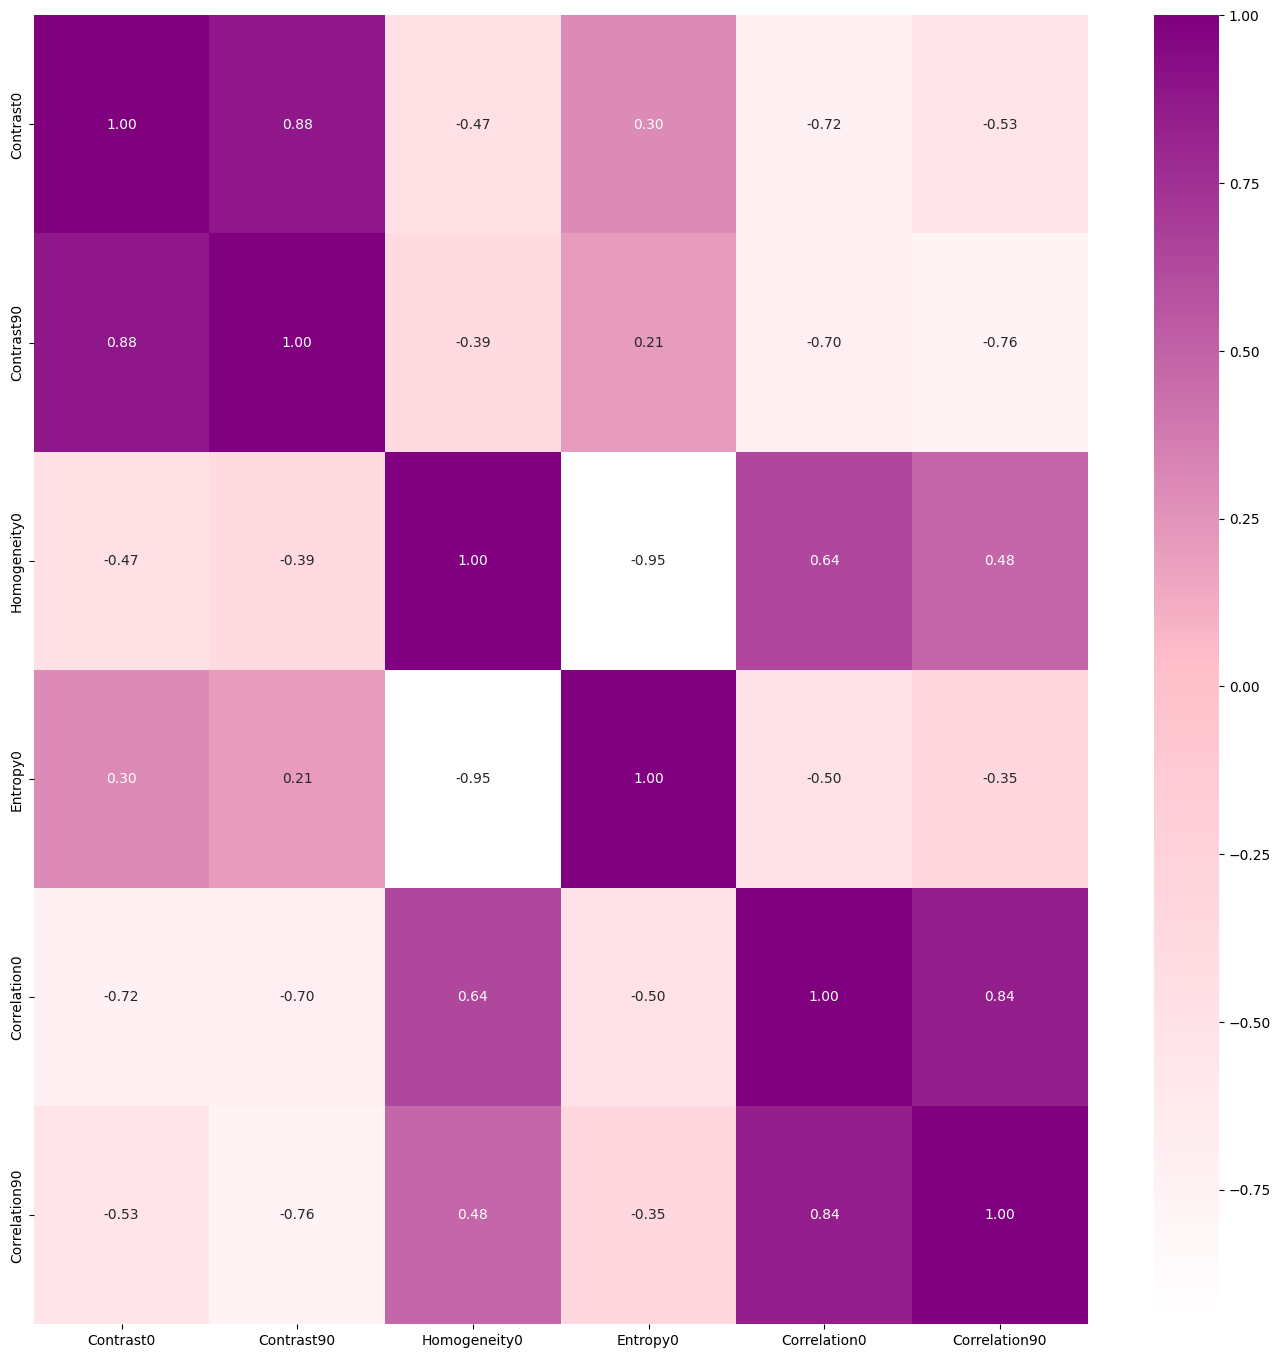

In [ ]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))

pink_cmap = LinearSegmentedColormap.from_list("pink_shade", ["white", "pink", "purple"], N=256)
sns.heatmap(x_new.corr(), annot=True, cmap=pink_cmap, fmt=".2f")

In [ ]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

(140, 6)
(60, 6)


In [ ]:

# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [ ]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=14, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

In [ ]:
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------RANDOM FOREST------")
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------RANDOM FOREST------
------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.99      0.99      0.99        69
      Rosacea       0.99      0.99      0.99        71

     accuracy                           0.99       140
    macro avg       0.99      0.99      0.99       140
 weighted avg       0.99      0.99      0.99       140

[[68  1]
 [ 1 70]]
Accuracy: 0.9857142857142858

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.88      0.90      0.89        31
      Rosacea       0.89      0.86      0.88        29

     accuracy                           0.88        60
    macro avg       0.88      0.88      0.88        60
 weighted avg       0.88      0.88      0.88        60

[[28  3]
 [ 4 25]]
Accuracy: 0.8833333333333333


In [ ]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------SVM------")
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)

------SVM------

------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.80      0.70      0.74        69
      Rosacea       0.74      0.83      0.78        71

     accuracy                           0.76       140
    macro avg       0.77      0.76      0.76       140
 weighted avg       0.77      0.76      0.76       140

[[48 21]
 [12 59]]
Accuracy: 0.7642857142857142

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.93      0.87      0.90        31
      Rosacea       0.87      0.93      0.90        29

     accuracy                           0.90        60
    macro avg       0.90      0.90      0.90        60
 weighted avg       0.90      0.90      0.90        60

[[27  4]
 [ 2 27]]
Accuracy: 0.9


In [ ]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------KNN------")
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)

------KNN------

------Training Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.76      0.77      0.76        69
      Rosacea       0.77      0.76      0.77        71

     accuracy                           0.76       140
    macro avg       0.76      0.76      0.76       140
 weighted avg       0.76      0.76      0.76       140

[[53 16]
 [17 54]]
Accuracy: 0.7642857142857142

------Testing Set------
               precision    recall  f1-score   support

Acne Vulgaris       0.76      0.84      0.80        31
      Rosacea       0.81      0.72      0.76        29

     accuracy                           0.78        60
    macro avg       0.79      0.78      0.78        60
 weighted avg       0.79      0.78      0.78        60

[[26  5]
 [ 8 21]]
Accuracy: 0.7833333333333333


In [ ]:
print("\n------Train Set RF------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

print("\n------Train Set SVM------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

print("\n------Train Set KNN------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)


------Train Set RF------
               precision    recall  f1-score   support

Acne Vulgaris       0.99      0.99      0.99        69
      Rosacea       0.99      0.99      0.99        71

     accuracy                           0.99       140
    macro avg       0.99      0.99      0.99       140
 weighted avg       0.99      0.99      0.99       140

[[68  1]
 [ 1 70]]
Accuracy: 0.9857142857142858

------Train Set SVM------
               precision    recall  f1-score   support

Acne Vulgaris       0.80      0.70      0.74        69
      Rosacea       0.74      0.83      0.78        71

     accuracy                           0.76       140
    macro avg       0.77      0.76      0.76       140
 weighted avg       0.77      0.76      0.76       140

[[48 21]
 [12 59]]
Accuracy: 0.7642857142857142

------Train Set KNN------
               precision    recall  f1-score   support

Acne Vulgaris       0.76      0.77      0.76        69
      Rosacea       0.77      0.76      0.77   

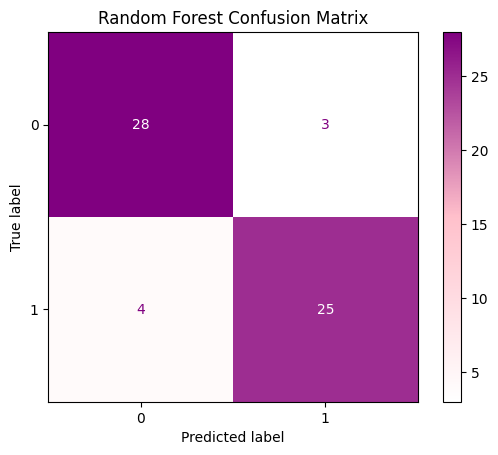

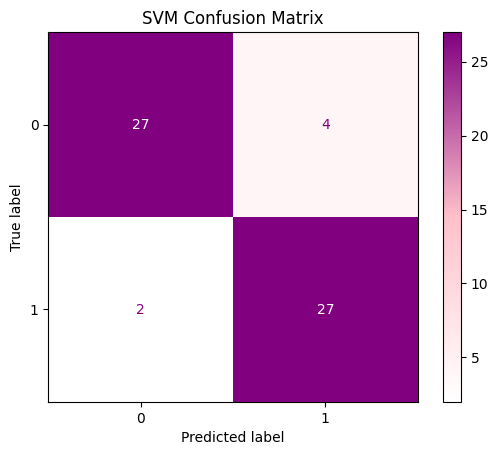

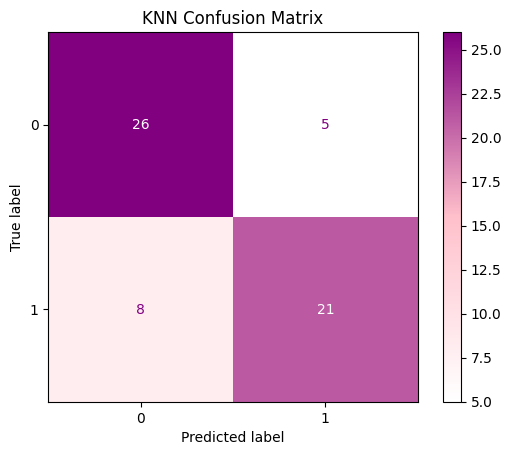

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=pink_cmap)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")